In [ ]:
!nvidia-smi

Sun Nov  8 20:13:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 4.4MB/s 
     |████████████████████████████████| 2.9MB 25.2MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
     |████████████████████████████████| 1.1MB 51.9MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.4.0


In [ ]:
#@title preload libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

#Importing modules
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import StratifiedKFold

#Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from statistics import mean
import time


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tech_debt_df = pd.read_csv('/content/drive/My Drive/tech_debt/technical_debt_dataset.csv',header=0,encoding='latin-1')#'utf-8')

In [ ]:
tech_debt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62275 entries, 0 to 62274
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   projectname     62275 non-null  object
 1   classification  62275 non-null  object
 2   commenttext     62275 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [ ]:
tech_debt_df.loc[tech_debt_df.classification == "DEFECT",'tag']=int(1)
tech_debt_df.loc[tech_debt_df.classification == "DESIGN",'tag']=int(1)
tech_debt_df.loc[tech_debt_df.classification == "DOCUMENTATION",'tag']=int(1)
tech_debt_df.loc[tech_debt_df.classification == "IMPLEMENTATION",'tag']=int(1)
tech_debt_df.loc[tech_debt_df.classification == "TEST",'tag']=int(1)
tech_debt_df.loc[tech_debt_df.classification == "WITHOUT_CLASSIFICATION",'tag']=int(0)

In [ ]:
tech_debt_df['tag']=LabelEncoder().fit_transform(tech_debt_df.tag)


In [ ]:
index = tech_debt_df.set_index('projectname')
#print(index)

jedit_df=index.loc[['jEdit-4.2']]
argouml_df=index.loc[['argouml']]
jmeter_df=index.loc[['apache-jmeter-2.10']]
sql_df=index.loc[['sql12']]
columba_df=index.loc[['columba-1.4-src']]
jruby_df=index.loc[['jruby-1.4.0']]
jfreechart_df=index.loc[['jfreechart-1.0.19']]
emf_df=index.loc[['emf-2.4.1']]
ant_df=index.loc[['apache-ant-1.7.0']]
hibernate_df=index.loc[['hibernate-distribution-3.3.2.GA']]
consolidated=index.loc[['jEdit-4.2','argouml','apache-jmeter-2.10','sql12','columba-1.4-src','jruby-1.4.0','jfreechart-1.0.19','emf-2.4.1','apache-ant-1.7.0','hibernate-distribution-3.3.2.GA'], ['classification', 'commenttext','tag']]


In [ ]:
import re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Removes punctuation and special characters
def  clean_text(df, text_field, new_text_field_name):
    print(len(df)) 
    #removing empty rows and rows whose comment text <= 2 chars
    #nan_value = float("NaN")
    #df.replace("", nan_value, inplace=True)    
    #df[text_field] = df[text_field].apply(lambda x: nan_value if len(x) <=2 else x )     
    df.dropna(subset = [text_field], inplace=True)
    print(len(df))
    #to lower case and remove hyperslinks and multiple spaces
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    
    return df

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

consolidated['commenttext'] = consolidated['commenttext'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
consolidated['commenttext'] = consolidated['commenttext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
consolidated['commenttext'] = consolidated['commenttext'].apply(lambda x: ' '.join([word for word in x.split() if len(word) < 15 ]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nan_value = float("NaN")
consolidated.replace("", nan_value, inplace=True)    
consolidated.dropna(subset = ['commenttext'], inplace=True)

In [ ]:
consolidated = clean_text(consolidated, 'commenttext', 'commenttext')
consolidated['commenttext'] = consolidated['commenttext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

53187
53187


In [ ]:
consolidated.dropna(subset = ['commenttext'], inplace=True)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in consolidated.commenttext:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


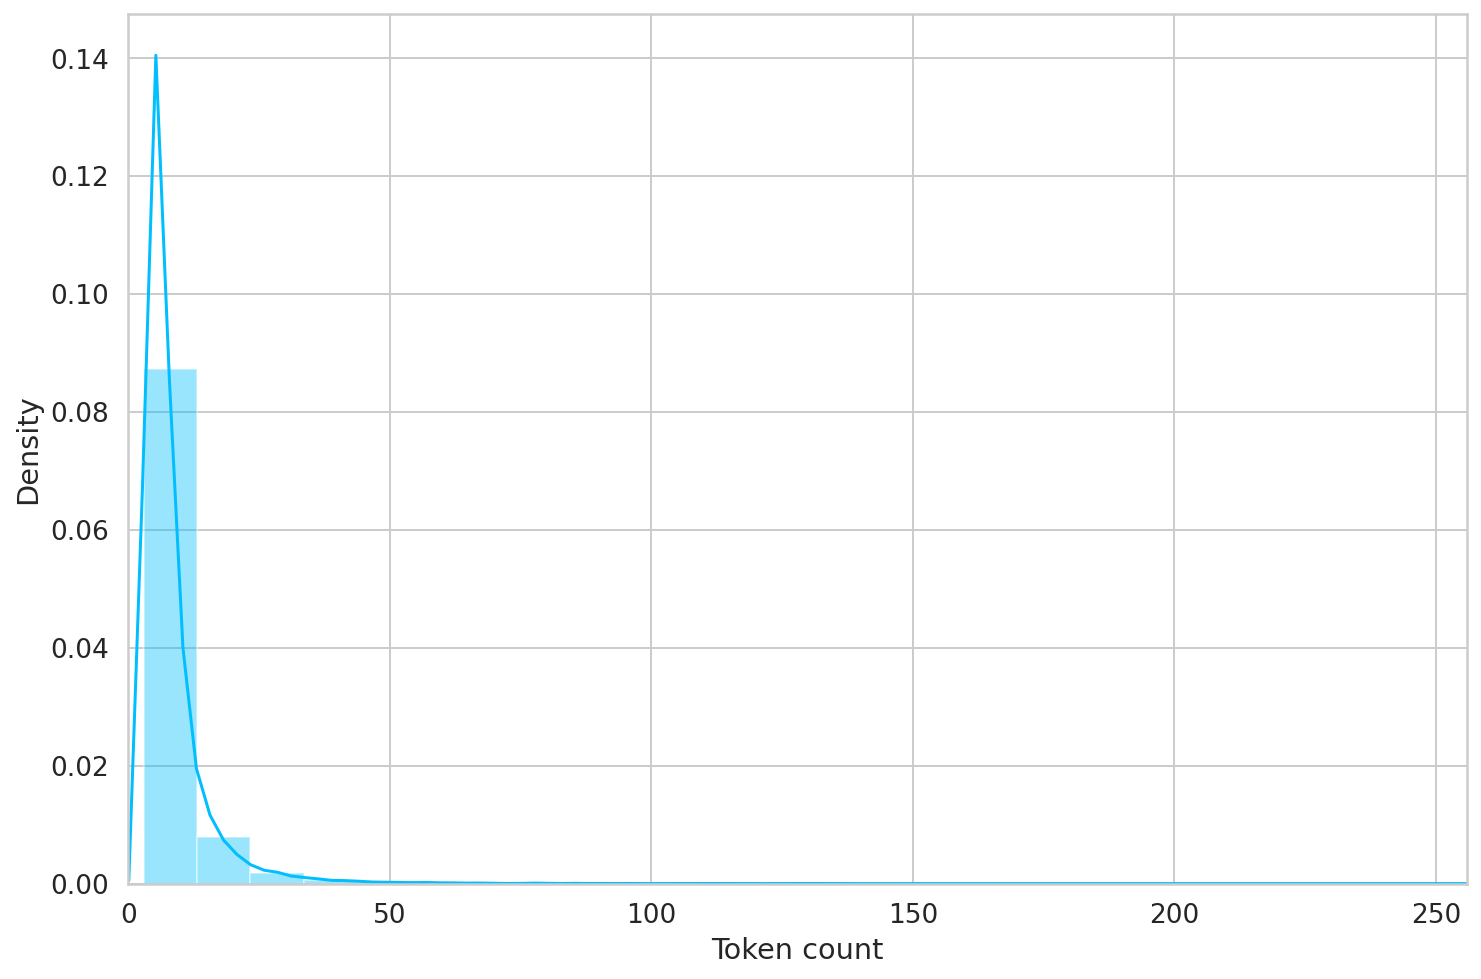

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 30

In [ ]:
class TechDebtDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comments)
  
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
#split data for training
df_train, df_test = train_test_split(consolidated, test_size=0.2,stratify=consolidated.tag, random_state=RANDOM_SEED)
df_train, df_val = train_test_split(df_train, test_size=0.1,stratify=df_train.tag, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((38294, 3), (4255, 3), (10638, 3))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TechDebtDataset(
    comments=df.commenttext.to_numpy(),
    targets=df.tag.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 30])
torch.Size([16, 30])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 30])
torch.Size([16, 30])


In [ ]:
EPOCHS = 1

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.11550867495807035 accuracy 0.9698908445187235


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.08416947650835198 accuracy 0.9776733254994124

CPU times: user 4min, sys: 59.4 s, total: 5min
Wall time: 5min 2s


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.9749952998683964

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  comment_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      comment_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return comment_texts, predictions, prediction_probs, real_values

In [ ]:
y_commenttext, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9824
           1       0.86      0.81      0.83       814

    accuracy                           0.97     10638
   macro avg       0.92      0.90      0.91     10638
weighted avg       0.97      0.97      0.97     10638



In [ ]:
df_test

,classification,commenttext,tag
projectname,,,
jEdit-4.2,WITHOUT_CLASSIFICATION,,0
jruby-1.4.0,WITHOUT_CLASSIFICATION,fixme correct recv argument doe produce desire...,0
apache-jmeter-2.10,WITHOUT_CLASSIFICATION,open,0
columba-1.4-src,WITHOUT_CLASSIFICATION,list mimeparts,0
hibernate-distribution-3.3.2.GA,WITHOUT_CLASSIFICATION,load type,0
...,...,...,...
emf-2.4.1,WITHOUT_CLASSIFICATION,create resource set,0
argouml,WITHOUT_CLASSIFICATION,,0
jEdit-4.2,WITHOUT_CLASSIFICATION,remove duplicate,0


In [ ]:
df_test.index =np.arange(1,len(df_test)+1)
df_test['id']=df_test.index + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test.head()

,classification,commenttext,tag,id
1,WITHOUT_CLASSIFICATION,note item name used changelanguage create loca...,0,2
2,WITHOUT_CLASSIFICATION,otherwise could check adapter implement interface,0,3
3,WITHOUT_CLASSIFICATION,nonnls,0,4
4,WITHOUT_CLASSIFICATION,line,0,5
5,WITHOUT_CLASSIFICATION,nonnls,0,6


In [ ]:
df_test.dropna(subset = ['commenttext'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test.shape

(10638, 4)

In [ ]:
nan_value = float("NaN")
df_test.replace("", nan_value, inplace=True)    
#df_test['commenttext'] = df_test['commenttext'].apply(lambda x: nan_value if len(x) <=2 else x )     
df_test.dropna(subset = ['commenttext'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_test.shape

(10585, 4)

In [ ]:
df_test.to_csv('/content/drive/My Drive/tech_debt/td_testdata_for_sentistrength_bert.tsv', sep = '\t',encoding='latin-1')

In [ ]:
df_test.shape

(10638, 4)

In [ ]:
test_senti_strength_rslts_df = pd.read_csv('/content/drive/My Drive/tech_debt/td_testdata_for_sentistrength_bert_classID.csv',sep = '\t',names=["ID","pos_score", "neg_score"])#,names=["ID","pos_score", "neg_score"])#'utf-8')

In [ ]:
print(len(test_senti_strength_rslts_df))

10638


In [ ]:
test_senti_strength_rslts_df['senti_combined_score'] =  test_senti_strength_rslts_df[['pos_score', 'neg_score']].sum(axis=1)

In [ ]:
test_senti_strength_rslts_df.head(10)

,ID,pos_score,neg_score,senti_combined_score
0,2,1,-1,0
1,3,1,-1,0
2,4,1,-1,0
3,5,1,-1,0
4,6,1,-1,0
5,7,1,-1,0
6,8,1,-1,0
7,9,1,-1,0
8,10,1,-1,0
9,11,1,-2,-1


In [ ]:
test_senti_strength_rslts_df.loc[test_senti_strength_rslts_df.senti_combined_score <= -1,'binary_sentiment']=1
test_senti_strength_rslts_df.loc[test_senti_strength_rslts_df.senti_combined_score >= 0, 'binary_sentiment']=0

In [ ]:
test_senti_strength_rslts_df.head(13)

,ID,pos_score,neg_score,senti_combined_score,binary_sentiment
0,2,1,-1,0,0.0
1,3,1,-1,0,0.0
2,4,1,-1,0,0.0
3,5,1,-1,0,0.0
4,6,1,-1,0,0.0
5,7,1,-1,0,0.0
6,8,1,-1,0,0.0
7,9,1,-1,0,0.0
8,10,1,-1,0,0.0
9,11,1,-2,-1,1.0


In [ ]:
df_test['pos_score']=test_senti_strength_rslts_df['pos_score'].values
df_test['neg_score']=test_senti_strength_rslts_df['neg_score'].values
df_test['binary_sentiment']=test_senti_strength_rslts_df['binary_sentiment'].values
#test_df['overall_score']=test_senti_strength_rslts_df['binary_result'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_test['binary_sentiment']=LabelEncoder().fit_transform(df_test.binary_sentiment)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test.head()

,classification,commenttext,tag,id,pos_score,neg_score,binary_sentiment
1,WITHOUT_CLASSIFICATION,note item name used changelanguage create loca...,0,2,1,-1,0
2,WITHOUT_CLASSIFICATION,otherwise could check adapter implement interface,0,3,1,-1,0
3,WITHOUT_CLASSIFICATION,nonnls,0,4,1,-1,0
4,WITHOUT_CLASSIFICATION,line,0,5,1,-1,0
5,WITHOUT_CLASSIFICATION,nonnls,0,6,1,-1,0


In [ ]:
senti_label=df_test.binary_sentiment.values

In [ ]:
y_pred_aug_bert=y_pred

In [ ]:
y_pred_ab_series=pd.Series(y_pred_aug_bert)

In [ ]:
for y_class_ind in range(len(y_pred_ab_series)):
    if y_pred_ab_series[y_class_ind] == 0 and senti_label[y_class_ind] == 1:
        y_pred_ab_series[y_class_ind]=1

In [ ]:
print(classification_report(y_test, y_pred_ab_series)) #, target_names=class_names))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9824
           1       0.41      0.86      0.56       814

    accuracy                           0.90     10638
   macro avg       0.70      0.88      0.75     10638
weighted avg       0.94      0.90      0.91     10638

